In [1]:
import pandas as pd
import numpy as np
from pylab import *
import scipy.stats as stats
from scipy.stats import kurtosis
import statistics
from sklearn.model_selection import train_test_split
import seaborn as sns
import shap
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import pickle

In [2]:
df= pd.read_pickle("../data/processed/clean_rows_df.pkl")  
df.head()

KeyboardInterrupt: 

In [ ]:
df.reset_index(inplace=True)
df.set_index(["spotName","TimeStamp"],inplace=True)

# ML su Voltage Curve

In [ ]:
exploded_voltage=pd.DataFrame(df.VoltageCurve.tolist(), index= df.index)

indice del primo valore per cui l'inclinazione della curva inizia a diventare negativa
Escludere i valori precedenti a questo indice per analizzare la curva

In [ ]:
#indice del primo valore per cui l'inclinazione della curva diventa negativa
#position=curva.diff()[curva.diff()==next(x for x in curva.diff() if x < 0)].index[0]
#curva_new è la curva senza il primo picco
#curva_new=curva.iloc[position:]
#plot(curva_new)

In [ ]:
exploded_voltage_diff=exploded_voltage.diff(axis=1)
exploded_voltage_diff=exploded_voltage_diff.drop(columns=0,axis=1)

In [ ]:
exploded_voltage_diff.iloc[:3].apply(lambda x: x.gt(0).idxmin(),axis=1)

spotName    TimeStamp          
60000_0_00  2019-11-07 12:29:06    8
            2019-11-07 12:29:26    8
            2019-11-07 12:29:26    7
dtype: int64

In [ ]:
exploded_voltage_diff["posizione"]=exploded_voltage_diff.apply(lambda x: x.gt(0).idxmin(),axis=1)

In [ ]:
#(exploded_voltage_diff.iloc[:3].apply(lambda x: x[x.posizione:],axis=1))

Non so come fare a rimuovere i primi n valori sulla base di posizione!!!!!

--> faccio una media di posizione arrotondata per eccesso e rimuovo le prime x=media(posizione) colonne del dataframe.

In [ ]:
#math.ceil(exploded_voltage_diff.posizione.mean())

In [ ]:
curve_ML=exploded_voltage.iloc[: , math.ceil(exploded_voltage_diff.posizione.mean()):]

## Estrazione Caratteristiche curve Voltage
Calcolo le caratteristiche delle curve su cui poi applicare algoritmi di ML:
- Media, Max, Min, Range, Varianza, Derivata, Curtosi...

In [ ]:
curve_ML["media"]=curve_ML.iloc[:,:616].apply(mean,axis=1)
curve_ML["mediana"]=curve_ML.iloc[:,:616].apply(lambda x : median(x[x.notna()]),axis=1)
curve_ML["max"]=curve_ML.iloc[:,:616].apply(max,axis=1)
curve_ML["min"]=curve_ML.iloc[:,:616].apply(min,axis=1)
curve_ML["varianza"]=curve_ML.iloc[:,:616].apply(var,axis=1)

In [ ]:
curve_ML["mediana"]=curve_ML.iloc[:,:616].apply(lambda x : median(x[x.notna()]),axis=1)

In [ ]:
#lunghezza come numero di valori non Null
curve_ML["lunghezza"]=curve_ML.iloc[:,:616].apply(lambda x: len(x[x.notna()]),axis=1)

In [ ]:
#range intesa come max-min
curve_ML["range"]=curve_ML.iloc[:,:616].apply(lambda x: x.max()-x.min(),axis=1)

In [ ]:
#calcolo della derivata come delta(y)/delta(x): ovvero range/lunghezza lista
curve_ML["derivata"]=curve_ML.apply(lambda x: x.range/len(x[:616][x[:616].notna()]),axis=1)

In [ ]:
#curtosi
curve_ML["kurtosis"]=curve_ML.iloc[:,:616].apply(lambda x: kurtosis(x[x.notna()]),axis=1)

In [ ]:
final_ML=curve_ML.iloc[:,616:]
final_ML.head()

media  mediana     max     min  \
spotName   TimeStamp                                                   
60000_0_00 2019-11-07 12:29:06  1475.613281   1249.0  2085.0  1199.0   
           2019-11-07 12:29:26  1691.521635   1624.0  2180.0  1393.0   
           2019-11-07 12:29:26  1683.105392   1622.0  2099.0  1383.0   
           2019-11-07 12:29:30  1657.260143   1603.0  2129.0  1353.0   
           2019-11-07 12:29:32  1696.208738   1639.5  2155.0  1399.0   

                                     varianza  lunghezza  range  derivata  \
spotName   TimeStamp                                                        
60000_0_00 2019-11-07 12:29:06  106775.116074        512  886.0  1.730469   
           2019-11-07 12:29:26   56225.182224        416  787.0  1.891827   
           2019-11-07 12:29:26   47841.104089        408  716.0  1.754902   
           2019-11-07 12:29:30   53271.247361        419  776.0  1.852029   
           2019-11-07 12:29:32   51611.204001        412  756.0  1.834951   

                                kurtosis  
spotName   TimeStamp                      
60000_0_00 2019-11-07 12:29:06 -1.339670  
           2019-11-07 12:29:26 -1.110572  
           2019-11-07 12:29:26 -1.325995  
           2019-11-07 12:29:30 -1.196977  
           2019-11-07 12:29:32 -1.182049

Prima di addestrare i modelli rimuoviamo le curve con lunghezza inferiore ai 300 ms, per poi rimuovere la feature "lunghezza" che non deve essere oggetto del processo di decisione.

In [ ]:
final_ML = final_ML.drop(final_ML[final_ML.lunghezza < 300].index)
final_ML.drop("lunghezza",axis=1,inplace=True)

In [ ]:
final_ML.to_pickle("../data/processed/volt_ML.pkl")

## Feature Engineering

In [3]:
final_ML= pd.read_pickle("../data/processed/volt_ML.pkl")  

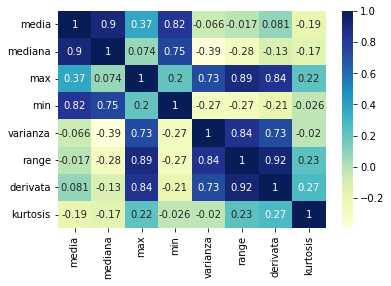

In [ ]:
ax=sns.heatmap(final_ML.corr(),annot=True,cmap="YlGnBu")

In [4]:
dummy=final_ML.drop(["media","range","max","min","varianza"],axis=1)

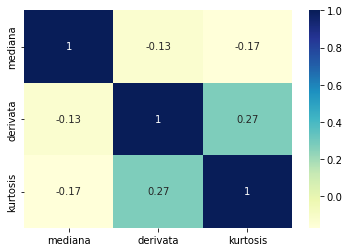

In [ ]:
ax=sns.heatmap(dummy.corr(),annot=True,cmap="YlGnBu")

## Isolation Forest

In [5]:
iso = IsolationForest(contamination="auto")
yhat_iForest = iso.fit_predict(dummy)

### XAI con Shap per iForest

In [6]:
df_train, df_test=train_test_split(dummy,train_size=0.8,shuffle=True,random_state=0)

In [7]:
# shap explainer
shap_values = shap.TreeExplainer(iso).shap_values(df_train)

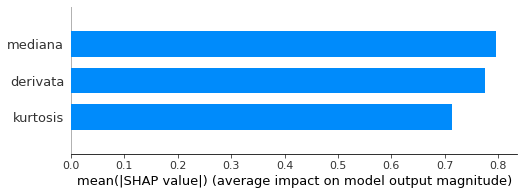

In [11]:
#A variable importance plot lists the most significant variables in descending order
shap.summary_plot(shap_values, df_test, plot_type="bar")

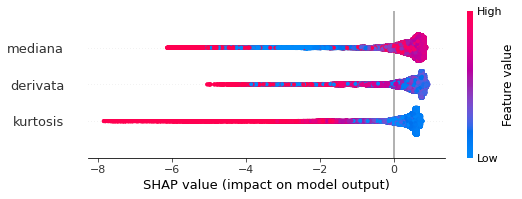

In [13]:
shap.summary_plot(shap_values, df_train)

This plot is made of all the dots in the train data. It demonstrates the following information:

- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lowerprediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: A high level of the “alcohol” content has a high and positive impact on the quality rating. The“high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the“volatile acidity” is negatively correlated with the target variable.

## Minimum Covariance Determinant

if the input variables have a Gaussian distribution, then simple statistical methods can be used to detect outliers. Check se distribuzione è gaussiana, metodo grafico e poi test di Shapiro-Wilk. La distribuzione non è gaussiana, p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

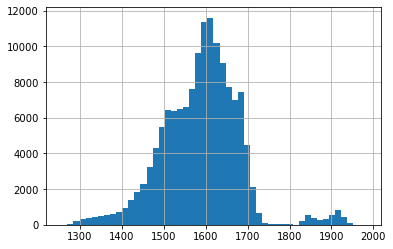

In [18]:
final_ML["media"].hist(bins=50);

In [18]:
from scipy.stats import normaltest

stat, p = normaltest(final_ML["media"])
print('stat=%.3f, p=%.3f\n' % (stat, p))

stat=8011.895, p=0.000



In [24]:
ee = EllipticEnvelope(contamination=0.1)
yhat_ee = ee.fit_predict(df_train)

## Local Outlier Factor

In [47]:
LOF = LocalOutlierFactor(contamination=0.2)
yhat_LOF = LOF.fit_predict(dummy)

## One-Class Support Vector Machine 

In [48]:
svm = OneClassSVM(nu=0.1)
yhat_SVM = svm.fit_predict(dummy)

## Aggiungo colonne delle varie yhat al df

In [74]:
len(dummy)

141671

In [49]:
dummy["iForest_volt"]=yhat_iForest
dummy["LOF_volt"]=yhat_LOF
dummy["SVM_volt"]=yhat_SVM

In [50]:
print(len(dummy[dummy["iForest_volt"]==-1]))
print(len(dummy[dummy["LOF_volt"]==-1]))
print(len(dummy[dummy["SVM_volt"]==-1]))

25632
27922
13962


In [42]:
#salvo nel file ML_voltage_with_anomalies il df originario con annesse le anomalie riscontrate nelle analisi
dummy.to_pickle("../data/processed/ML_voltage_with_anomalies.pkl")

In [46]:
#salvataggio del modello iforest che utilizzeremo nel deploy
with open(r'..\Models\iForest_volt.pkl','wb') as file:
    pickle.dump(iso,file)

## Plot per valutare curve anomale
Le curve anomale rilevate sembrerebbero essere quelle con i cali anomali, sia attraverso drop repentini che cali più graduali ma precoci rispetto alla media

***L'algoritmo di ML avrà un bias per i cali rispetto ai picchi poichè i cali repentini rappresentano l'anomalia più evidente e diffusa del processo !!***

I processi con i cali più graduali spesso non vengono identificati da anomaly_drop ma sono caratterizzati da un alto valore di %volt_anomalies

In [ ]:
df.VoltageCurve

In [ ]:
60166_0_00	2020-03-12 15:46:18

df= pd.read_pickle("../data/with_stat_anomalies.pkl")  

In [ ]:
df.loc[('60166_0_00', '2020-03-12 15:46:18'), :]

In [ ]:
curva=df.loc[('60166_0_00', '2020-03-12 15:46:18'), :].VoltageCurve
plot(curva.values[0])